In [12]:
import socket
import time
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
from IPython.display import Audio
import scipy.io.wavfile
import pickle
import os

## Discover devices

### Multicast method

Run cell then plugin device, it's startup should be detected if on same network

In [39]:
import socket

MULTICAST_GROUP = '239.0.0.1'
MULTICAST_PORT = 12345


sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM, socket.IPPROTO_UDP)

sock.bind(('', MULTICAST_PORT))

group = socket.inet_aton(MULTICAST_GROUP)
sock.setsockopt(socket.IPPROTO_IP, socket.IP_ADD_MEMBERSHIP, group + socket.inet_aton('0.0.0.0'))


while True:
    data, address = sock.recvfrom(1024)
    print(f"Received {data.decode('utf-8')} from {address}")
    break

sock.close()


KeyboardInterrupt: 

In [15]:
socket.gethostbyname('onju-coral-V3')

'192.168.137.178'

## Send TCP
This kills two birds, sends a greeting audio clip and gives the device the server IP to send mic data to

In [16]:
DEVICE = 'onju-coral-V3'

In [42]:
filename = "data/hello_imhere.wav"
audio = AudioSegment.from_file(filename)
audio = audio.set_channels(1)
audio = audio.set_frame_rate(16000)
audio = audio.set_sample_width(2)  # int16 sample width

audio_data = audio.raw_data
timeout = 1*60*60
volume = 10

# header[0]   0xAA for audio
# header[1:2] mic timeout in seconds (after audio is done playing)
# header[3]   volume, in units of bitshift (~ 8 to 16 for full range)
# header[4]   fade rate of LED's VAD visualization
# header[5]   not used

header = bytes([0xaa, (timeout & 0xff00) >> 8, timeout & 0xff, volume, 8, 0])

s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((DEVICE, 3001))
tic = time.time()
s.sendall(header)
time.sleep(0.02)
s.sendall(audio_data)
s.close()
print(f"Time taken: {(time.time() - tic):.3f}s")


Time taken: 0.026s


## Receive UDP

In [43]:
UDP_IP = '0.0.0.0'
UDP_PORT = 3000

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind((UDP_IP, UDP_PORT))

WIDTH = 2

d=[]
i=0

try:
    print("Listening for UDP packets on port 3000")
    while True:
        data, addr = sock.recvfrom(960)
        if(i%10==0):
            print(f"{i}: Received {len(data)} bytes from {addr}")
        i+=1
        d.append(data)
except KeyboardInterrupt:
    print("Exiting...")
except Exception as e:
    print("Error occurred:")
    print(e)
finally:
    sock.close()


Listening for UDP packets on port 3000
0: Received 960 bytes from ('192.168.137.178', 3000)
10: Received 960 bytes from ('192.168.137.178', 3000)
20: Received 960 bytes from ('192.168.137.178', 3000)
30: Received 960 bytes from ('192.168.137.178', 3000)
40: Received 960 bytes from ('192.168.137.178', 3000)
50: Received 960 bytes from ('192.168.137.178', 3000)
60: Received 960 bytes from ('192.168.137.178', 3000)
70: Received 960 bytes from ('192.168.137.178', 3000)
80: Received 960 bytes from ('192.168.137.178', 3000)
90: Received 960 bytes from ('192.168.137.178', 3000)
100: Received 960 bytes from ('192.168.137.178', 3000)
110: Received 960 bytes from ('192.168.137.178', 3000)
120: Received 960 bytes from ('192.168.137.178', 3000)
Exiting...


In [44]:
# save audio
d_np = np.frombuffer(d[0], dtype=np.int16)
for a in d[1:]:
    d_np = np.concatenate((d_np, np.frombuffer(a, dtype=np.int16)))

print(f"delta: {np.max(d_np)-np.min(d_np)}\nmean: {np.mean(d_np):.1f}\nstd: {np.std(d_np):.3f}")

#remove offset
d_np = (d_np - np.mean(d_np)).astype(np.int16)

os.makedirs('data', exist_ok=True)
fname = 'data/received.wav'
scipy.io.wavfile.write(fname, 16000, d_np)
np.save(fname.replace('.wav', '.npy'), d_np)

Audio(fname)

delta: 18446
mean: -13141.0
std: 851.011


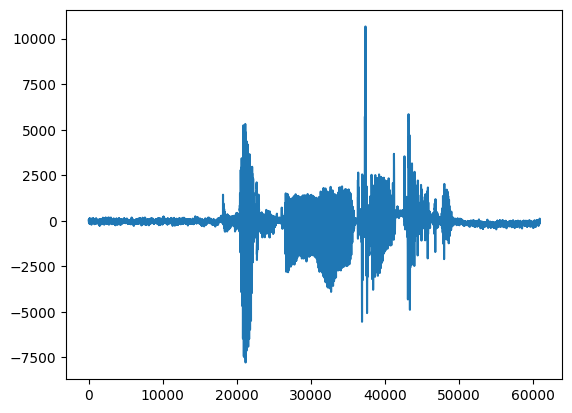

In [46]:
plt.plot(d_np)

## Test LED's

In [32]:
def send_header(device, header):
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect((device, 3001))
    s.sendall(header)
    s.close()

In [48]:
# header[0]   0xBB for set LED command
# header[1]   bitmask of which LED's to set
# header[2:4] RGB color

for i in range(20):
    R,G,B = plt.cm.hsv(i/20)[:3]
    send_header(DEVICE, bytes([0xbb, 0b00111111, int(R*20), int(G*20), int(B*20),0]))
    time.sleep(0.2)

send_header(DEVICE, bytes([0xbb, 0b00111111, 0, 0, 0,0]))

In [47]:
# header[0]   0xCC for LED blink command
# header[1]   starting intensity for rampdown
# header[2:4] RGB color
# header[5]   fade rate

send_header(DEVICE, bytes([0xcc, 0xff, 255, 255, 255,10]))